# Simulation of spin chain dynamics

In [1]:
import qutip
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from scipy.optimize import curve_fit
from scipy.linalg import expm
jtplot.style(theme='grade3',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

## Initialize Hamiltanion Heisenberg Model

In [2]:
J=1*2*np.pi
n=4
h1=-J*(qutip.tensor(qutip.sigmap(),qutip.sigmam())+qutip.tensor(qutip.sigmam(),qutip.sigmap()))-2*J*qutip.tensor(qutip.sigmaz(),qutip.sigmaz())
ham=0
for i in range(n-1):
    if i==0:
        if n>2:
            s=[qutip.qeye(2)]*(n-2)
            ham+=qutip.tensor(h1,qutip.tensor(*s))
        else:
            ham+=h1
    elif i==n-2:
        s=[qutip.qeye(2)]*(n-2)
        ham+=qutip.tensor(qutip.tensor(*s),h1)
    else:
        s1=[qutip.qeye(2)]*i
        s2=[qutip.qeye(2)]*(n-2-i)
        ham+=qutip.tensor(qutip.tensor(*s1),h1,qutip.tensor(*s2))
#print(tmp)
print(ham)

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[-37.69911184   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.         -12.56637061  -6.28318531   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.          -6.28318531  12.56637061   0.          -6.28318531
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -12.56637061   0.
   -6.28318531   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.          -6.28318531   0.          12.56637061
    0.           0.           0.          -

## Initial state

In [3]:
## basic ket
b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
b=list(set(b))
statelist=[]
statekettodmlist=[]
for i in b:
    tmp=qutip.basis(2,i[0])
    for j in i[1:]:
        tmp=qutip.tensor(tmp,qutip.basis(2,j))
    statelist.append(tmp)
    statekettodmlist.append(qutip.ket2dm(tmp))
print(b)

## Antiferromagnetical state
initialstate=qutip.basis(2,0)
for i in range(1,n):
    if i%2==0:
        initialstate=qutip.tensor(initialstate,qutip.basis(2,0))
    else:
        initialstate=qutip.tensor(initialstate,qutip.basis(2,1))
        
#print(initialstate)

[(1, 0, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1)]


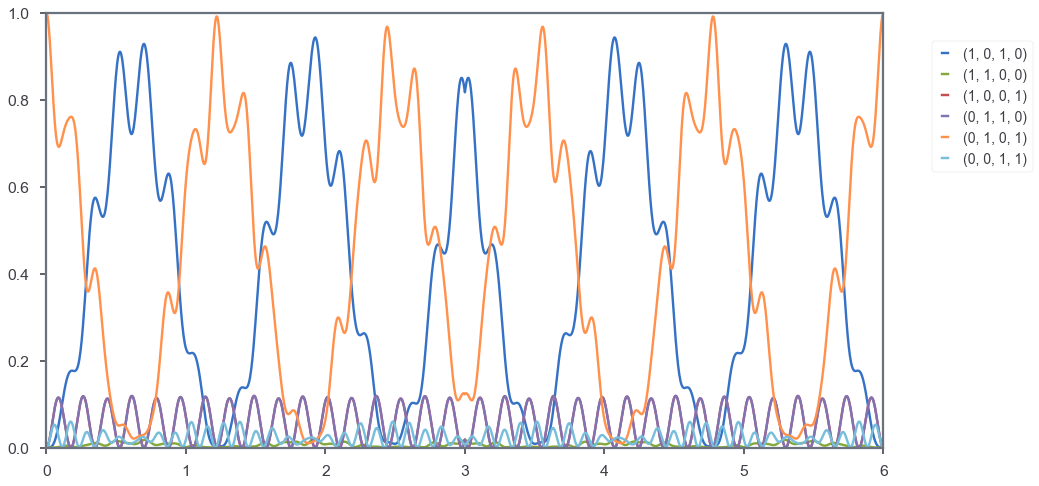

In [4]:
times = np.linspace(0.0, 3*1.0, 700)
finalre=qutip.mesolve(ham,initialstate,times,[],statekettodmlist)
tmps=qutip.mesolve(ham,initialstate,[0,times[-1]],[])
finalstate1=tmps.states[-1]
finalre2=qutip.mesolve(-ham,finalstate1,times,[],statekettodmlist)
plt.figure(figsize=(15,8))
plt.xlim((times[0],2*times[-1]))
plt.ylim((0,1))
for i in range(len(statekettodmlist[:])):
    plt.plot(np.append(times,times+times[-1]),np.append(finalre.expect[i],finalre2.expect[i]),label=str(b[i]))
    #plt.plot(times+times[-1],finalre2.expect[i],label=str(b[i]))
plt.legend(loc='best',
           fontsize='17',bbox_to_anchor=(1.05,0.95), numpoints=15,prop={'size':14}, handlelength=1.0, handletextpad=0.8)

plt.grid()

## Hamiltion for 2 atoms in double well
basic kets are ($|0,\uparrow \uparrow>,|\uparrow,\uparrow>,|\uparrow \uparrow,0>$), ($|0,\downarrow \downarrow>,|\downarrow,\downarrow>,|\downarrow \downarrow,0>$),  ($|\uparrow,\downarrow>,|\downarrow,\uparrow>,|0,\uparrow \downarrow>,|\uparrow \downarrow,0>$)

In [5]:
def func(x,b,c):
    return b+(1-b)*np.cos(c*x)

In [6]:
statelist=[r'$|0,\uparrow \uparrow>$',r'$|\uparrow,\uparrow>$',r'$|\uparrow \uparrow,0>$', r'$|0,\downarrow \downarrow>$',r'$|\downarrow,\downarrow>$',r'$|\downarrow \downarrow,0>$',
           r'$|\uparrow,\downarrow>$',r'$|\downarrow,\uparrow>$',r'$|0,\uparrow \downarrow>$',r'$|\uparrow \downarrow,0>$']

In [7]:
def hami(J,U,td):
    h0=np.array([[U+2*td,2**0.5*J,0],[2**0.5*J,td,2**0.5*J],[0,2**0.5*J,U]])
    h1=np.array([[U,2**0.5*J,0],[2**0.5*J,td,2**0.5*J],[0,2**0.5*J,U+2*td]])
    h2=np.array([[0,0,J,J],[0,2*td,J,J],[J,J,U+td,0],[J,J,0,U+td]])
    s=np.zeros((10,10))
#     coff=0*0.5*(J**2/(U+td)+J**2/(U-td))
#     coff1=+1*(0.75*J**2/(U+td)+0.25*J**2/(U+td))+coff-td/2
#     coff2=+1*(0.25*J**2/(U-td)+0.75*J**2/(U-td))+coff+td/2
#     tmp=(1*2*coff2,coff1+coff2,1*2*coff1,-1*2*coff2,-(coff1+coff2),-1*2*coff1,coff1-coff2,-coff1+coff2,0,0)
#     #print(tmp)
#     tmp=np.diag(tmp)
    s[:3,:3]=h0
    s[3:6,3:6]=h1
    s[6:10,6:10]=h2
#     s-=0*tmp
    ham2=qutip.Qobj(s)
    return ham2

def haminodepend(J,U,td):
    h0=np.array([[U+2*td,2**0.5*J,0],[2**0.5*J,td,2**0.5*J],[0,2**0.5*J,U]])
    h1=np.array([[U+2*td,2**0.5*J,0],[2**0.5*J,td,2**0.5*J],[0,2**0.5*J,U+0*td]])
    h2=np.array([[td,0,J,J],[0,td,J,J],[J,J,U+2*td,0],[J,J,0,U+0*td]])
    s=np.zeros((10,10))
#     coff=0*0.5*(J**2/(U+td)+J**2/(U-td))
#     coff1=+1*(0.75*J**2/(U+td)+0.25*J**2/(U+td))+coff-td/2
#     coff2=+1*(0.25*J**2/(U-td)+0.75*J**2/(U-td))+coff+td/2
#     tmp=(1*2*coff2,coff1+coff2,1*2*coff1,-1*2*coff2,-(coff1+coff2),-1*2*coff1,coff1-coff2,-coff1+coff2,0,0)
#     #print(tmp)
#     tmp=np.diag(tmp)
    s[:3,:3]=h0
    s[3:6,3:6]=h1
    s[6:10,6:10]=h2
#     s-=0*tmp
    ham2=qutip.Qobj(s)
    return ham2

def reverse(J,U,td):
    coff=0*0.5*(J**2/(U+td)+J**2/(U-td))
    coff1=-1*(0.75*J**2/(U+td)+0.25*J**2/(U-td))+coff-td/2
    coff2=-1*(0.25*J**2/(U+td)+0.75*J**2/(U-td))+coff+td/2
    tmp=(1*2*coff2,coff1+coff2,1*2*coff1,-1*2*coff2,-(coff1+coff2),-1*2*coff1,coff1-coff2,-coff1+coff2,0,0)
    tmp=np.diag(tmp)
    return qutip.Qobj(tmp)


hami(1,1,2)
reverse(1,1,2)

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 3.33333333  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.66666667  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -2.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -3.33333333  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.66666667  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          2.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -2.66666667  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          2.6666

In [22]:
initialstate2=(0*qutip.basis(10,6)+1*qutip.basis(10,7)+0*qutip.basis(10,4)+0*qutip.basis(10,1))
initialstate2=initialstate2.unit()

In [23]:
initialstate2

Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.08712095-0.69747888j]
 [-0.70206112-0.08331719j]
 [ 0.02146299-0.00885988j]
 [ 0.07263695+0.01692006j]]
CPU times: user 2.56 s, sys: 177 ms, total: 2.74 s
Wall time: 3.23 s


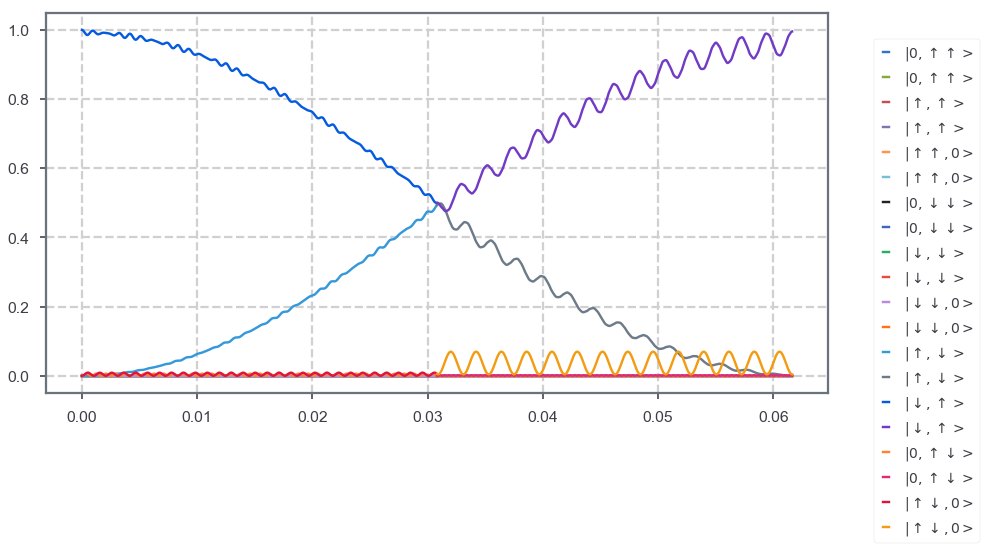

In [26]:
%%time
J=46.28*2*np.pi#0.5*2*np.pi*2020
U=1068.79*2*np.pi#20*J
td=117*2*np.pi#*J

def superexhange(U,J,td,showfig=True):
    if 2*U**2<td**2:
        #return 0
        raise Exception('U is too small compare to td')
    period=np.abs(2*np.pi/(J**2/(U-td)+J**2/(U+td)))
    #print(period)
    ham2=haminodepend(J,U,td)
    ham3=haminodepend(J,U,np.sqrt(2*U**2-td**2))
    times=np.linspace(0,0.5*period/4,1000)
    #es = qutip.ode2es(ham2, initialstate2)
    #result2=qutip.esval(es,times)
    result2=qutip.sesolve(ham2,initialstate2,times,[],options=qutip.Options(nsteps=200000))
    result3=qutip.sesolve(ham3,result2.states[-1],times,[],options=qutip.Options(nsteps=200000))
    #print(qutip.expect(qutip.ket2dm(initialstate2),result2.states))
    if showfig:
        plt.figure(figsize=(14,7))
        for i in range(0,10):
            #print(i,statelist[i])
            plt.plot(times,qutip.expect(qutip.ket2dm(qutip.basis(10,i)),result2.states),label=statelist[i])
            plt.plot(times+times[-1],qutip.expect(qutip.ket2dm(qutip.basis(10,i)),result3.states),label=statelist[i])
        plt.legend(loc='best',
           fontsize='17',bbox_to_anchor=(1.05,0.95), numpoints=15,prop={'size':14}, handlelength=1.0, handletextpad=0.8)
    print(result2.states[-1].full())
    corr=np.cov(qutip.expect(qutip.ket2dm(initialstate2),result2.states),qutip.expect(qutip.ket2dm(initialstate2),result3.states)[-1::-1])
    unexpectpro=np.max(qutip.expect(qutip.ket2dm(qutip.basis(10,8)),result3.states)+qutip.expect(qutip.ket2dm(qutip.basis(10,9)),result3.states))
    unexpectpro2=np.max(qutip.expect(qutip.ket2dm(qutip.basis(10,8)),result2.states)+qutip.expect(qutip.ket2dm(qutip.basis(10,9)),result2.states))
    return qutip.expect(qutip.ket2dm(initialstate2),result3.states[-1]),corr[0][1],np.max([unexpectpro,unexpectpro2]),period

superexhange(U,J,td)
# Ulist=np.linspace(20,80,20)
# tdlist=np.linspace(0,25,20)
# resultlist=[]

# for a in Ulist:
#     for b in tdlist:
#         resultlist.append(superexhange(a*J,J,b*J,showfig=False))
#         if b==tdlist[-1]:
#             print(a)
# resultlist=np.array(resultlist)
# resultlist
            
    

In [19]:
resulty=resultlist[:,0].reshape((20,20))
plt.figure(figsize=(14,10))
plt.title('InitialState Fidelity')
plt.pcolor(tdlist,Ulist,resulty,vmax=1,vmin=0.95)
plt.colorbar()
resulty=resultlist[:,1].reshape((20,20))
plt.figure(figsize=(14,10))
plt.title('Covarance')
plt.pcolor(tdlist,Ulist,resulty,vmax=0.13,vmin=0.1)
plt.colorbar()
resulty=resultlist[:,2].reshape((20,20))
plt.figure(figsize=(14,10))
plt.title('Maxiumium doublon Probility')
plt.pcolor(tdlist,Ulist,resulty,vmax=0.2,vmin=0)
plt.colorbar()
resulty=resultlist[:,3].reshape((20,20))
plt.figure(figsize=(14,10))
plt.title('Period')
plt.pcolor(tdlist,Ulist,resulty)
plt.colorbar()

NameError: name 'resultlist' is not defined

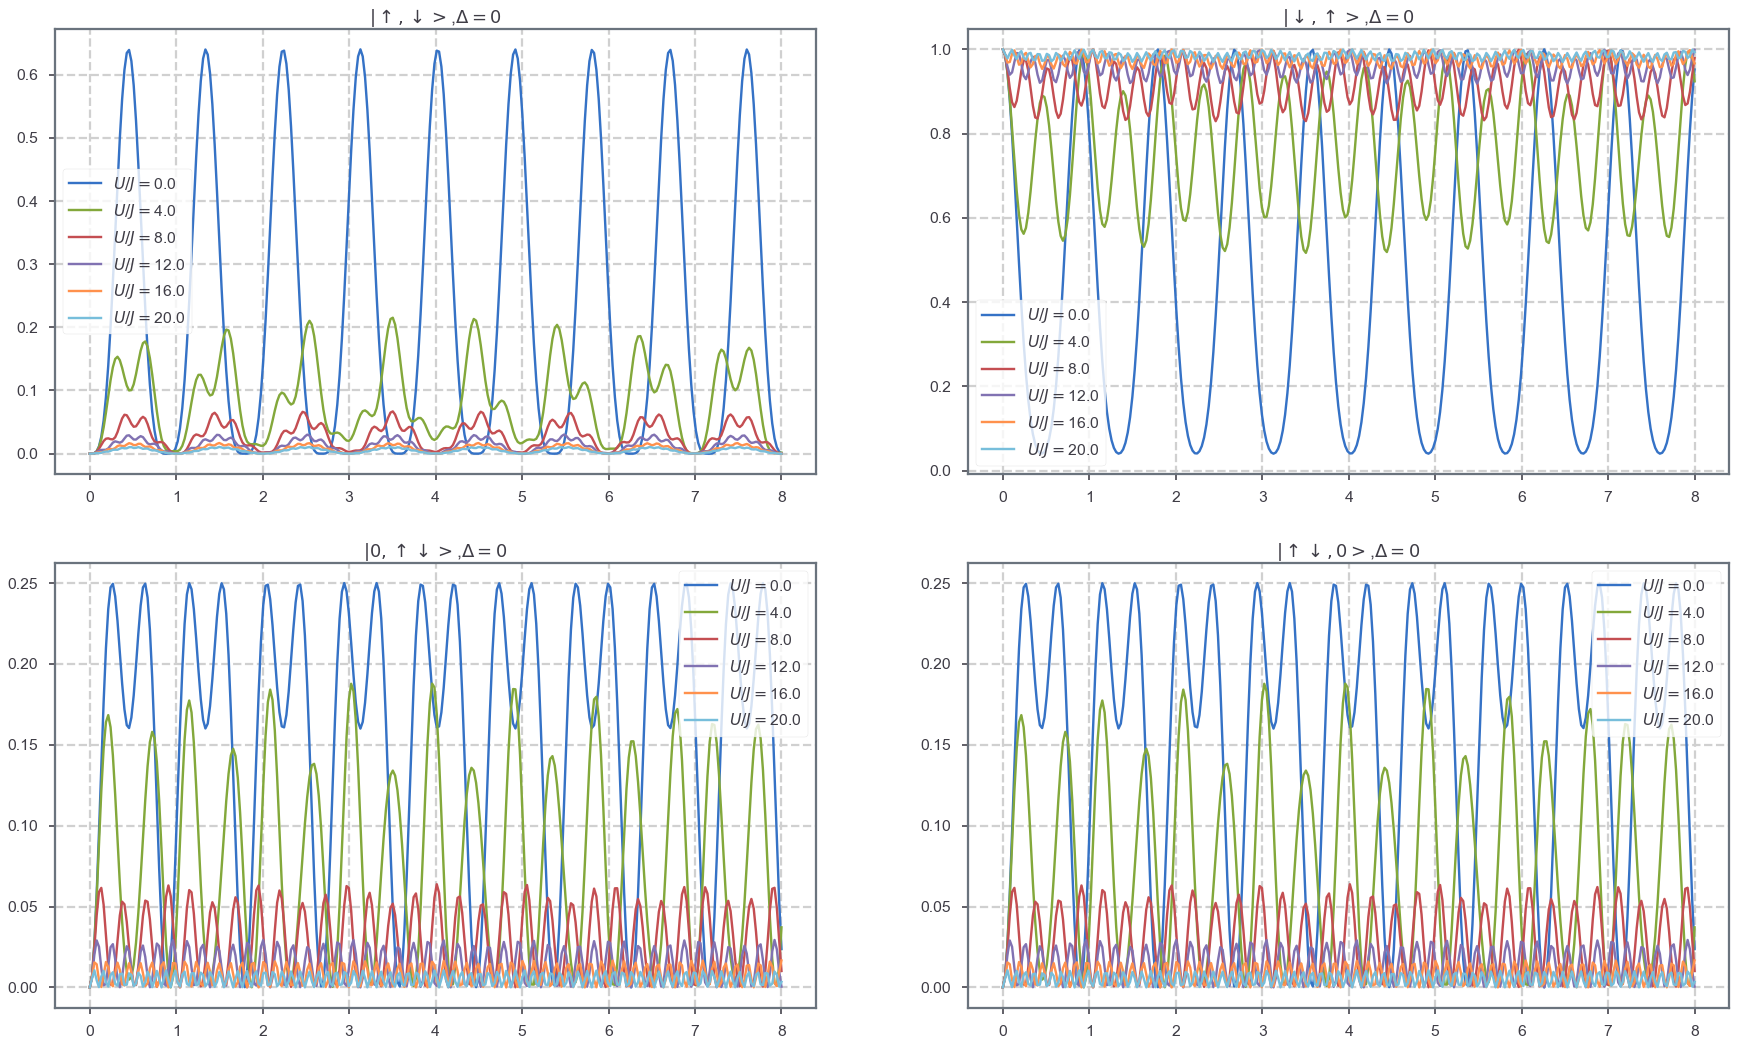

In [27]:
J=1*np.pi
U=20.0*J
td=1.0*J
a=np.linspace(0,20,6)
times=np.linspace(0,8*np.pi/J,300)
fig,ax=plt.subplots(2,2,figsize=(30,18))
freq={}
for i in a:
    ham2=hami(J,i*J,td)
    result2=qutip.mesolve(ham2,initialstate2,times,[],[qutip.ket2dm(qutip.basis(10,6)),qutip.ket2dm(qutip.basis(10,7)),qutip.ket2dm(qutip.basis(10,8)),qutip.ket2dm(qutip.basis(10,9))])
#     fittedresult=curve_fit(func,times,result2.expect[0])#,bounds=(0, 20), method='trf')
#     freqtmp=fittedresult[0][1]
#     lowertmp=1-fittedresult[0][0]
#     freq[i]=[freqtmp,lowertmp]
#     print(fittedresult[0])
    #ax[0][0].plot(times,func(times,fittedresult[0][0],fittedresult[0][1]))
    for j in range(4):
        ax[j//2][j%2].plot(times,result2.expect[j],label='$U/J=$'+str(i))
        
for j in range(4):
    ax[j//2][j%2].set_title(statelist[6+j]+',$\Delta=0$')
for axis in ax[0]:
    axis.legend(loc='best')
for axis in ax[1]:
    axis.legend(loc='best')
# plt.figure(figsize=(15,9))
# plt.scatter(a,[freq[i][0] for i in a])

{0.0: 0.0, 0.044444444444444446: 0.0, 0.08888888888888889: 0.0, 0.13333333333333333: 0.0, 0.17777777777777778: 0.0, 0.22222222222222224: 0.0, 0.26666666666666666: 0.0, 0.3111111111111111: 0.0, 0.35555555555555557: 0.0, 0.4: 0.0}


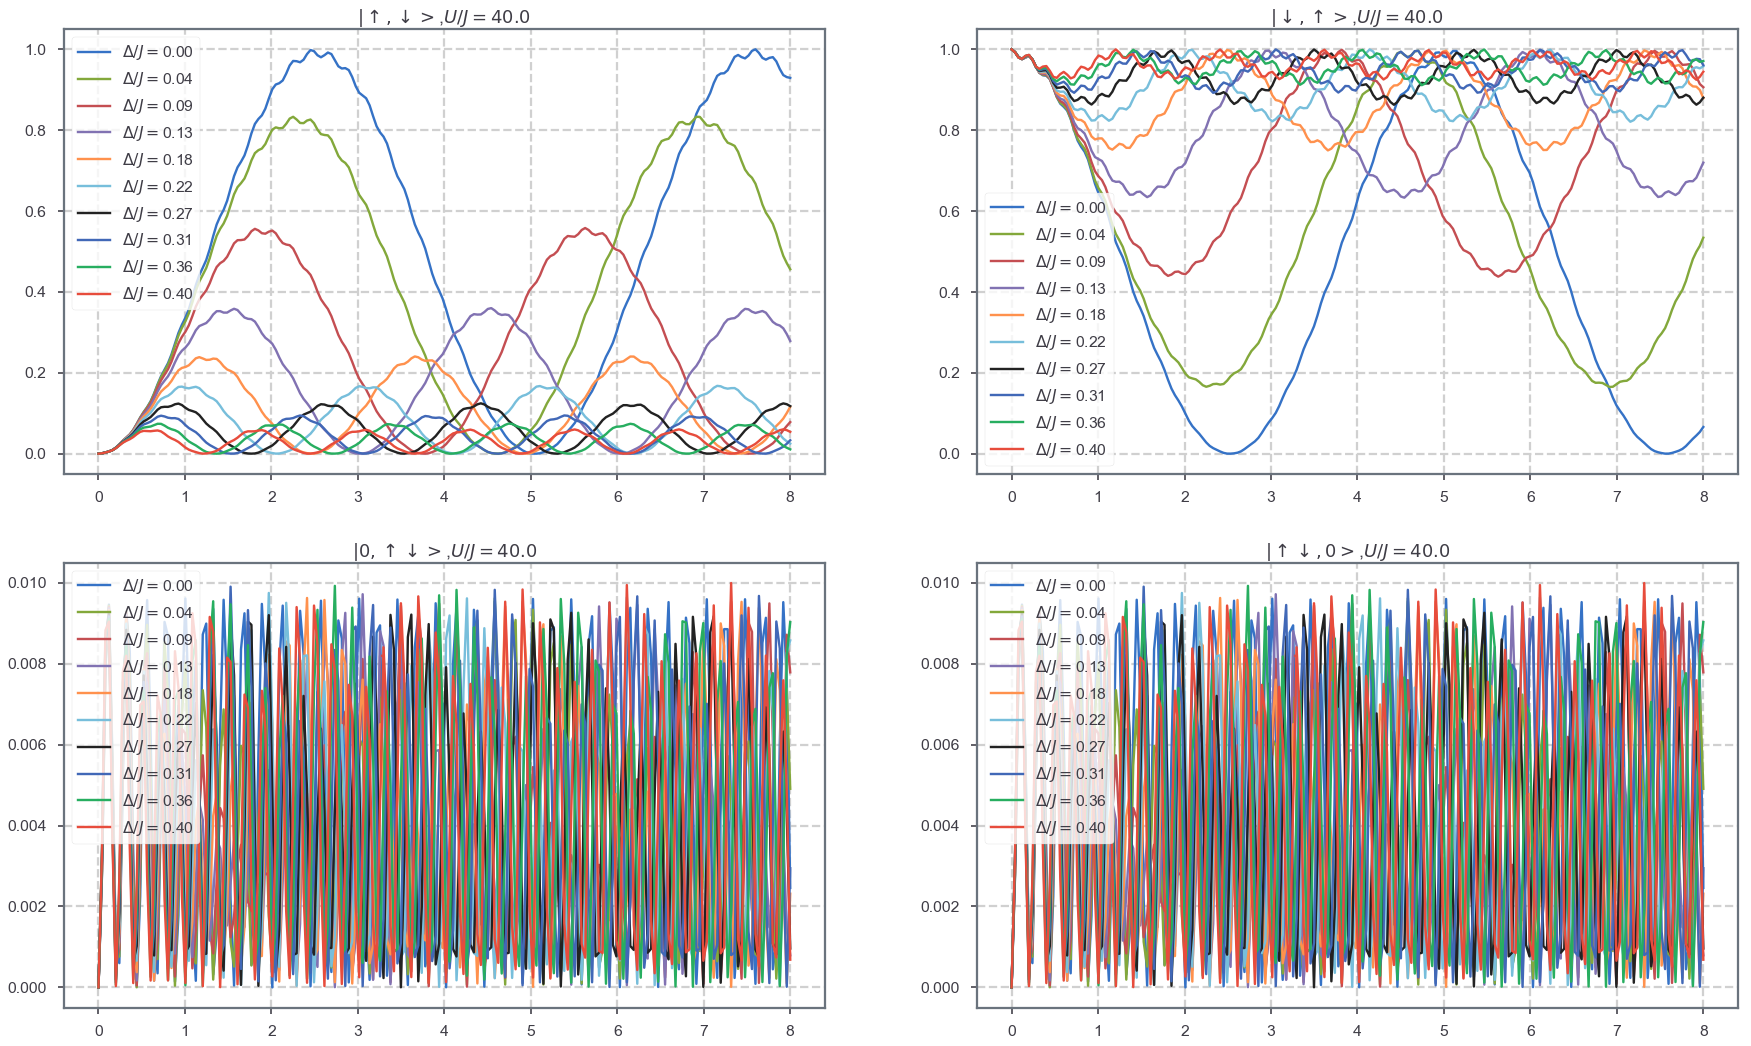

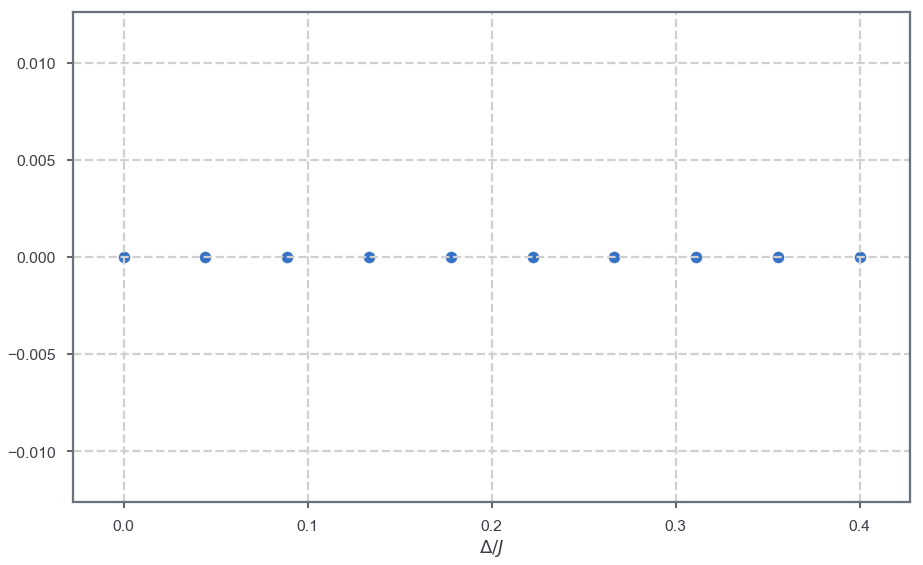

In [28]:
J=1*2*np.pi
U=20.0*J
td=0.0*J
a=np.linspace(0.0,0.4,10)
times=np.linspace(0,2*np.pi/(J**2/U)*0.4,200)
fig,ax=plt.subplots(2,2,figsize=(30,18))
amptmp={}


for i in a:
    ham2=hami(J,U,i*J)
    result2=qutip.mesolve(ham2,initialstate2,times,[],[qutip.ket2dm(qutip.basis(10,6)),qutip.ket2dm(qutip.basis(10,7)),qutip.ket2dm(qutip.basis(10,8)),qutip.ket2dm(qutip.basis(10,9))])
    for j in range(4):
        ax[j//2][j%2].plot(times,result2.expect[j],label='$\Delta/J=$%0.2f'%i)
    amptmp[i]=np.min(result2.expect[0])
for j in range(4):
    ax[j//2][j%2].set_title(statelist[6+j]+',$U/J=40.0$')
for axis in ax[0]:
    axis.legend(loc='best')
for axis in ax[1]:
    axis.legend(loc='best')
print(amptmp)
plt.figure(figsize=(15,9))
plt.xlabel('$\Delta/J$')
plt.scatter(a,[amptmp[i] for i in a])

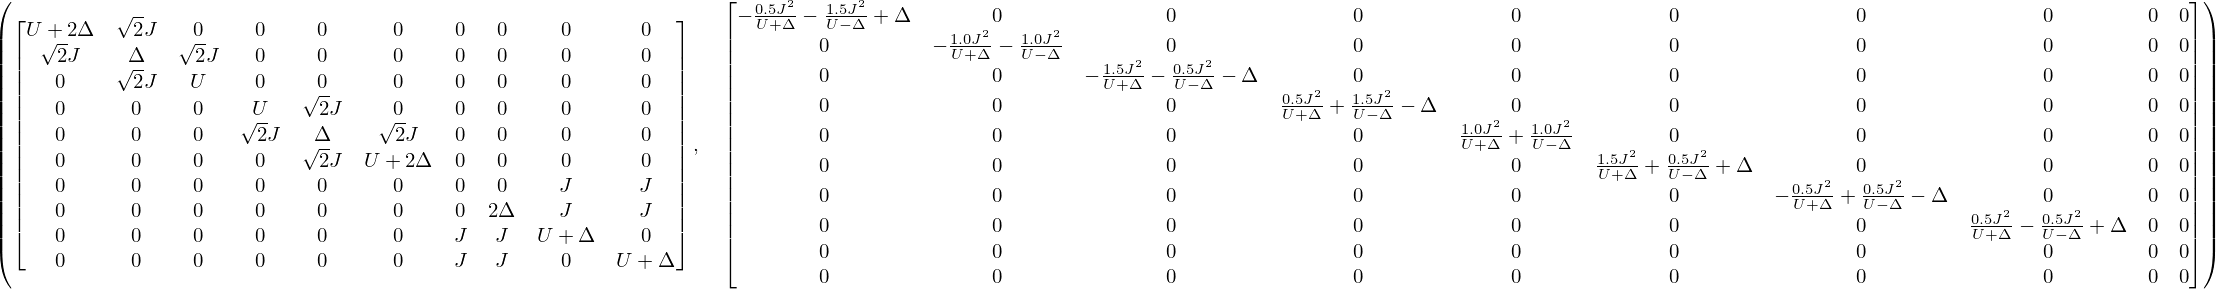

In [29]:
from sympy import *
init_printing()
# h0=np.array([[U+td,2**0.5*J,0],[2**0.5*J,0,2**0.5*J],[0,2**0.5*J,U-td]])
# h1=np.array([[U-td,2**0.5*J,0],[2**0.5*J,0,2**0.5*J],[0,2**0.5*J,U+td]])
# h2=np.array([[-td,0,J,J],[0,td,J,J],[J,J,U,0],[J,J,0,U]])
# s=np.zeros((10,10))
# s[:3,:3]=h0
# s[3:6,3:6]=h1
# s[6:10,6:10]=h2
symU,symJ,symtd=symbols('U J \Delta')
symh0=Matrix([[symU+2*symtd,sqrt(2)*symJ,0],[sqrt(2)*symJ,symtd,sqrt(2)*symJ],[0,sqrt(2)*symJ,symU]])
symh1=Matrix([[symU,sqrt(2)*symJ,0],[sqrt(2)*symJ,symtd,sqrt(2)*symJ],[0,sqrt(2)*symJ,symU+2*symtd]])
symh2=Matrix([[0,0,symJ,symJ],[0,2*symtd,symJ,symJ],[symJ,symJ,symU+symtd,0],[symJ,symJ,0,symU+symtd]])
# s=np.zeros((10,10))
# coff=0*0.5*(J**2/(U+td)+J**2/(U-td))
symcoff1=-(0.75*symJ**2/(symU+symtd)+0.25*symJ**2/(symU-symtd)+symtd/2)
symcoff2=-(0.25*symJ**2/(symU+symtd)+0.75*symJ**2/(symU-symtd)-symtd/2)
symtmp=(1*2*symcoff2,symcoff1+symcoff2,1*2*symcoff1,-1*2*symcoff2,-(symcoff1+symcoff2),-1*2*symcoff1,symcoff1-symcoff2,-symcoff1+symcoff2,0,0)
#pprint(tmp)
# h0=Matrix([[U+td,sqrt(2)*J,0],[2**0.5*J,0,2**0.5*J],[0,2**0.5*J,U-td]])
# h1=Matrix([[U-td,2**0.5*J,0],[2**0.5*J,0,2**0.5*J],[0,2**0.5*J,U+td]])
# h2=Matrix([[-td,0,J,J],[0,td,J,J],[J,J,U,0],[J,J,0,U]])
symham=-diag(*symtmp)+diag(symh0,symh1,symh2)
symham
diag(symh0,symh1,symh2),diag(*symtmp)
#h2.diagonalize()

## Show the critical value of $\Delta$ which make the tunneling between sites in double well vanished.

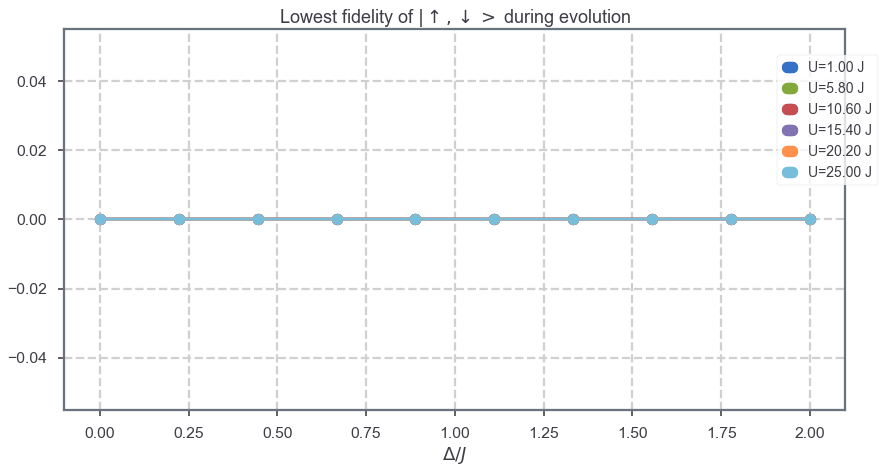

In [30]:
def lowestamp(U,J,deltalist,state,type='min'):
    amptmp={}
    for i in deltalist:
        ham2=hami(J,U*J,i*J)
        result2=qutip.mesolve(ham2,initialstate2,times,[],[qutip.ket2dm(qutip.basis(10,6)),qutip.ket2dm(qutip.basis(10,7)),qutip.ket2dm(qutip.basis(10,8)),qutip.ket2dm(qutip.basis(10,9))])
        if type=='min':
            amptmp[i]=np.min(result2.expect[state])
        elif type=='max':
            amptmp[i]=np.max(result2.expect[state])
    return amptmp
        
plt.figure(figsize=(14,7))
plt.xlabel('$\Delta/J$')
plt.title(r'Lowest fidelity of $|\uparrow,\downarrow>$ during evolution')# |\uparraw,\downarraw>$')
Ulist=np.linspace(1,25,6)
a=np.linspace(0.0,2,10)
times=np.linspace(0,20*np.pi/(J**2),400)
# result=qutip.parfor(lowestamp,Ulist,[J],[a],[0],type='min',show_progressbar=True)
# print(results)
for Ui in Ulist:
    a=np.linspace(0.0,2,10)
    #times=np.linspace(0,2*np.pi/(J**2)*0.4,200)
    times=np.linspace(0,20*np.pi/(J**2),400)
    amptmp=lowestamp(Ui,J,a,0)
    plt.plot(a,[amptmp[i] for i in a],'o-',label='U=%0.2f J'%Ui)
    plt.legend(loc='best',
           fontsize='17',bbox_to_anchor=(1.05,0.95), numpoints=15,prop={'size':14}, handlelength=1.0, handletextpad=0.8)

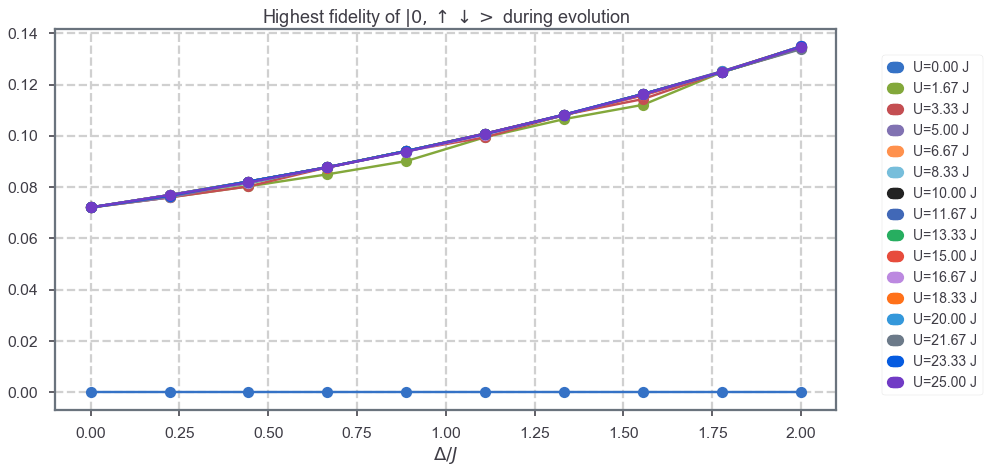

In [31]:
plt.figure(figsize=(14,7))
plt.xlabel('$\Delta/J$')
plt.title(r'Highest fidelity of $|0,\uparrow \downarrow>$ during evolution')# |\uparraw,\downarraw>$')
Ulist=np.linspace(0,25,16)
for Ui in Ulist:
    a=np.linspace(0.0,2,10)
    times=np.linspace(0,20*np.pi/(J**2),400)
    #times=np.linspace(0,20*np.pi/(J**2),400)
    amptmp=lowestamp(J,Ui,a,2,type='max')
    plt.plot(a,[amptmp[i] for i in a],'o-',label='U=%0.2f J'%Ui)
    plt.legend(loc='best',
           fontsize='17',bbox_to_anchor=(1.05,0.95), numpoints=15,prop={'size':14}, handlelength=1.0, handletextpad=0.8)

In [32]:
def tamp(U,J,delta):
    ham2=hami(J,U*J,delta*J)
    amptmp={}
    result2=qutip.mesolve(ham2,initialstate2,times,[],[qutip.ket2dm(qutip.basis(10,6)),qutip.ket2dm(qutip.basis(10,7)),qutip.ket2dm(qutip.basis(10,8)),qutip.ket2dm(qutip.basis(10,9))])
    amptmp['min']=[np.min(result2.expect[state]) for state in range(3)]
    amptmp['max']=[np.max(result2.expect[state]) for state in range(3)]
    return amptmp

# Ulist=np.linspace(1,25,16)
# a=np.linspace(0.0,2,16)
# result=qutip.parfor(tamp,Ulist,np.array([J]*16),a)

In [39]:
initialstate2=0.5*(1*qutip.basis(10,6)+1*qutip.basis(10,7)+1*qutip.basis(10,1)+1*qutip.basis(10,4))
initialstate2=initialstate2.unit()
targetstate=0.5*(1*qutip.basis(10,6)+1*qutip.basis(10,7)+1*qutip.basis(10,1)-1*qutip.basis(10,4))


def twopdy(U,J,td,ax,method='qutip',showfig=True):    
    period=np.pi*(J**2/(U-td)+J**2/(U+td))**(-1)
    #print(period)
    times=np.linspace(0,period,500)
    ham2=hami(J,U,td)
    ham3=hami(J,U,np.sqrt(2*U**2-td**2))
    reverse2=reverse(J,U,td)
    reverse3=reverse(J,U,np.sqrt(2*U**2-td**2))
    initialfidelity=[]
    targetfidelity=[]
    if method=='qutip':
        for t in times:
            #result2=qutip.essolve(ham2,initialstate2,[0,t],[],[])
            es = qutip.ode2es(ham2, initialstate2)
            result2=qutip.esval(es,[0,t])
            result3=qutip.essolve(-1*reverse2,result2[-1],[0,t],[],[qutip.ket2dm(initialstate2),qutip.ket2dm(targetstate)])
            initialfidelity.append(result3.expect[0][-1])
            targetfidelity.append(result3.expect[1][-1])
    elif method=='expm':    
        for t in times:
            state=np.dot(expm(1*1j*reverse2.full()*t),np.dot(expm(-1j*ham2.full()*t),initialstate2.full()))
            #state3=np.dot(expm(-1*1j*ham3.full()*t),np.dot(expm(1j*reverse3.full()*t),state))
            #evostates.append(state)
            initialfidelity.append((np.abs(np.dot(state.T,initialstate2.full()))**2)[0][0])
            targetfidelity.append((np.abs(np.dot(state.T,targetstate.full()))**2)[0][0])
    #print(initialfidelity)
    #     fittedresult=curve_fit(func,times,result2.expect[0])#,bounds=(0, 20), method='trf')
    #     freqtmp=fittedresult[0][1]
    #     lowertmp=1-fittedresult[0][0]
    #     freq[i]=[freqtmp,lowertmp]
    #     print(fittedresult[0])
        #ax[0][0].plot(times,func(times,fittedresult[0][0],fittedresult[0][1]))
    if showfig:
        ax.set_ylim((0,1))
        ax.set_title('U=%0.4f Er,J=%0.4f Er,$\Delta$=%0.4f Er'%(U/(2*np.pi*2020),J/(2*np.pi*2020),td/(2*np.pi*2020)))
        ax.set_xlim((0,times[-1]))
        ax.set_xlabel('Time/s')
        ax.plot(times,initialfidelity,'o-',ms=3.5,label='Initialstate')
        ax.plot(times,targetfidelity,'o-',ms=3.5,label='targetstate')
        ax.legend(loc='best')
    return np.max(targetfidelity)

1
2
3
4
5
6
7
8
9
10
CPU times: user 11min 22s, sys: 8.85 s, total: 11min 31s
Wall time: 12min 13s


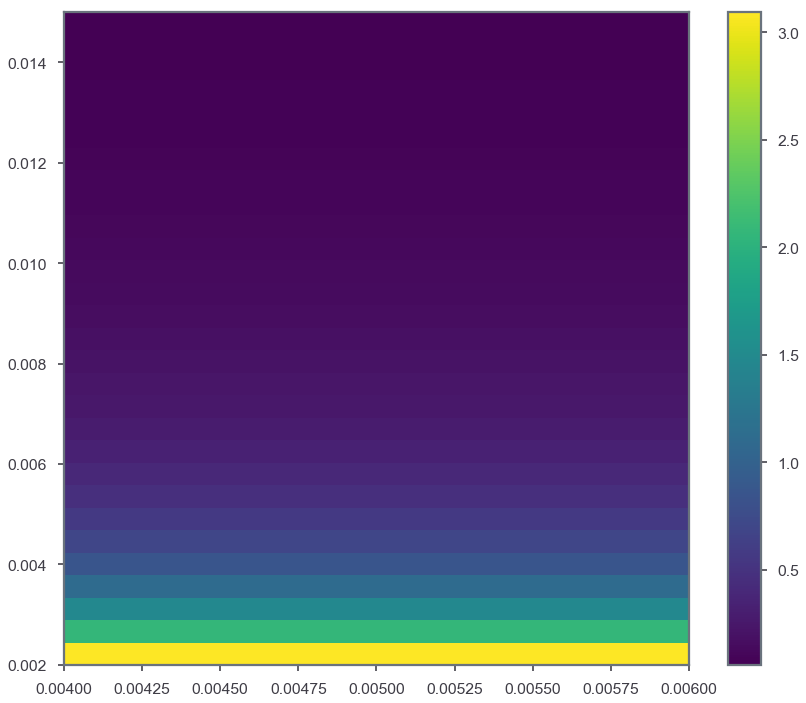

In [40]:
%%time
#fig,ax=plt.subplots(1,1,figsize=(14,8))

#twopdy(0.2*2*np.pi*2020,0.06*2*np.pi*2020,0.1*2*np.pi*2020,ax,method='expm',showfig=True)

Jlist=np.linspace(0.002,0.015,30)*2*np.pi*2020
deltalist=np.linspace(0.004,0.006,28)*2*np.pi*2020
parvec=[]
timevec=[]
toal=len(Jlist)*len(deltalist)
i=0
progranum=[int(toal*0.1*(i+1)) for i in range(10)]
for ji in Jlist:
    for det in deltalist:
        i+=1
        #print(ji,det)
        parvec.append(twopdy(0.2*2*np.pi*2020,ji,det,0,method='expm',showfig=False))
        timevec.append(np.pi*(ji**2/(0.2*2*np.pi*2020-det)+ji**2/(0.2*2*np.pi*2020+det))**(-1)/2)
        if i in progranum:
            print(progranum.index(i)+1)
        
        #print(parvec[-1])

parvece=np.array(parvec)
parvece=parvece.reshape((len(Jlist),len(deltalist)))
timevece=np.array(timevec)
timevece=timevece.reshape((len(Jlist),len(deltalist)))

plt.figure(figsize=(14,12))
plt.pcolor(deltalist/(2*np.pi*2020),Jlist/(2*np.pi*2020),timevece)
plt.colorbar()

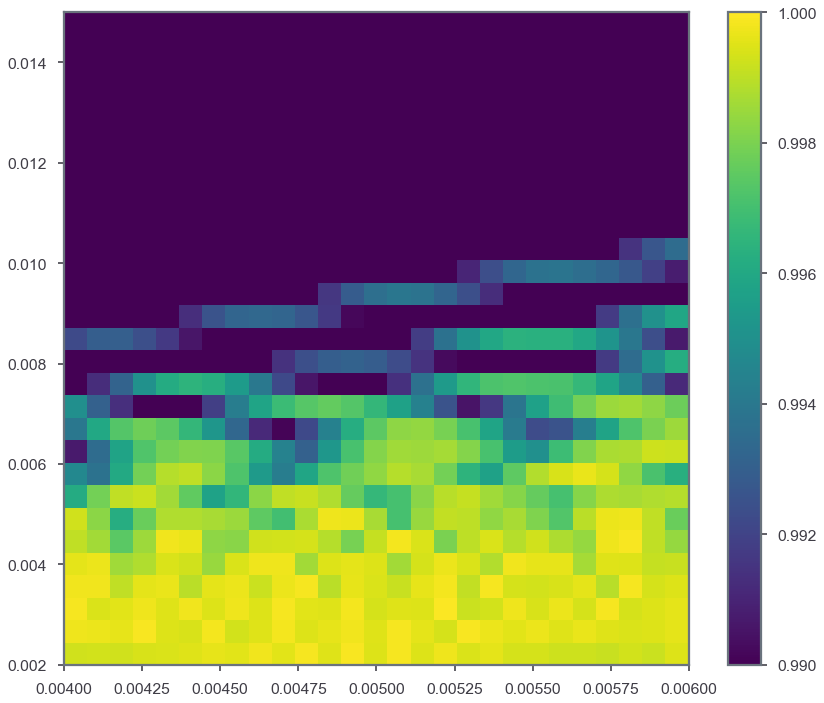

In [43]:
plt.figure(figsize=(14,12))
#parvece=parvece.reshape((6,8))
plt.pcolor(deltalist/(2*np.pi*2020),Jlist/(2*np.pi*2020),parvece,vmin=0.99, vmax=1)
plt.colorbar()

CPU times: user 1min 21s, sys: 2.15 s, total: 1min 23s
Wall time: 1min 52s


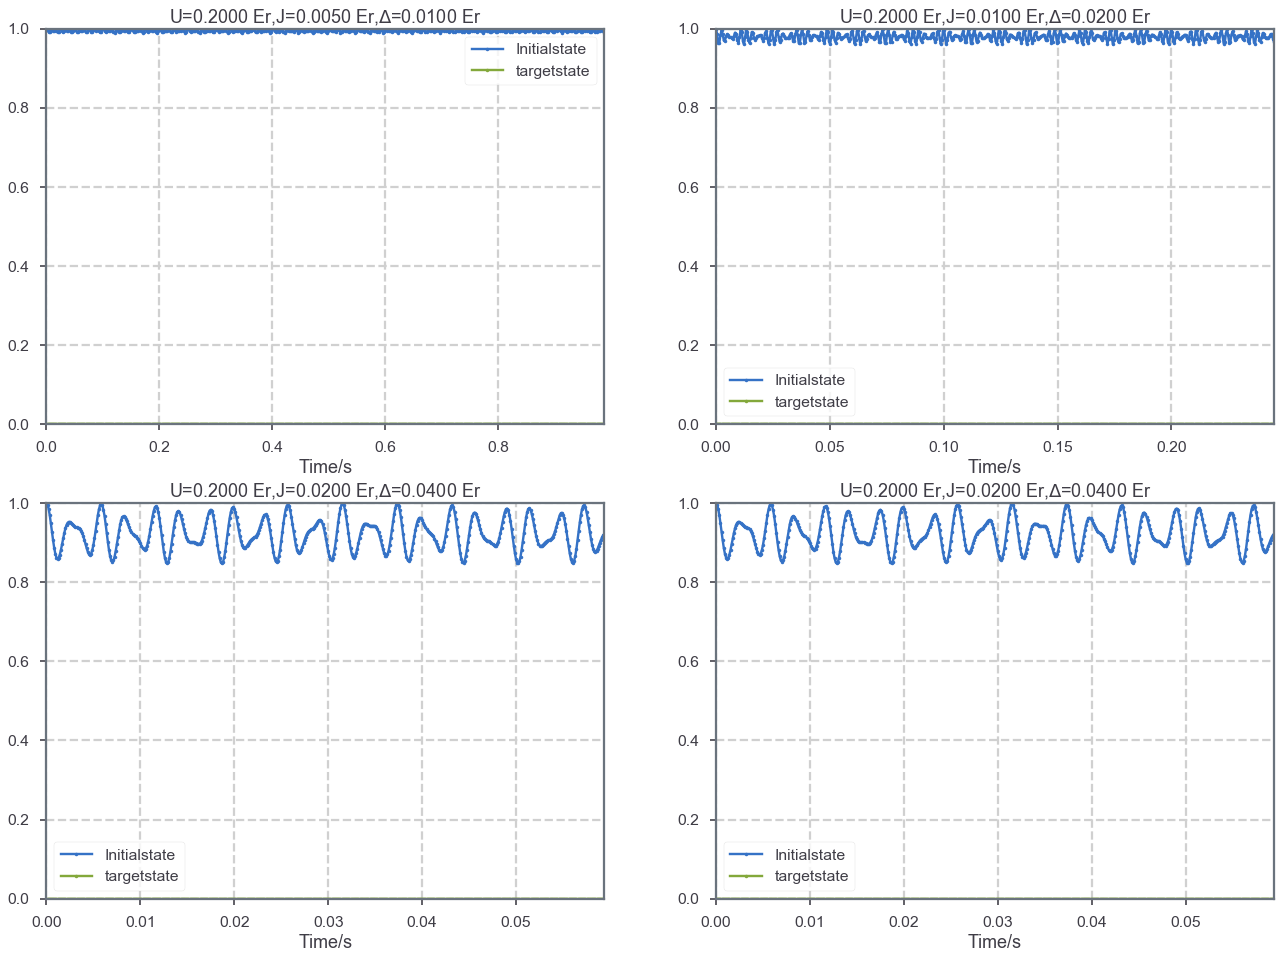

In [47]:
%%time

initialstate2=0.5*(0*qutip.basis(10,6)+0*qutip.basis(10,7)+1*qutip.basis(10,1)+0*qutip.basis(10,4))
initialstate2=initialstate2.unit()
targetstate=0.5*(0*qutip.basis(10,6)+0*qutip.basis(10,7)+0*qutip.basis(10,1)-1*qutip.basis(10,4))
targetstate=targetstate.unit()

#np.linspace(0,20,6)

fig,axt=plt.subplots(2,2,figsize=(22,16))
ax=axt[0][0]

J=0.005*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.01*2*np.pi*2020

twopdy(U,J,td,ax)

ax=axt[0][1]
ax.set_ylim((0,1))

J=0.01*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.02*2*np.pi*2020

twopdy(U,J,td,ax)

ax=axt[1][0]
ax.set_ylim((0,1))

J=0.02*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.04*2*np.pi*2020

twopdy(U,J,td,ax)
 

ax=axt[1][1]
ax.set_ylim((0,1))
# J=0.03*2*np.pi*2020
# U=0.2*2*np.pi*2020
# td=0.09*2*np.pi*2020
twopdy(U,J,td,ax) 
# for j in range(4):
#     ax[j//2][j%2].set_title(statelist[6+j]+',$\Delta=0$')
# for axis in ax:
#     axis.legend(loc='best')
# for axis in ax[1]:
#     axis.legend(loc='best')
# plt.figure(figsize=(15,9))
# plt.scatter(a,[freq[i][0] for i in a])

CPU times: user 6.04 s, sys: 498 ms, total: 6.54 s
Wall time: 7.75 s


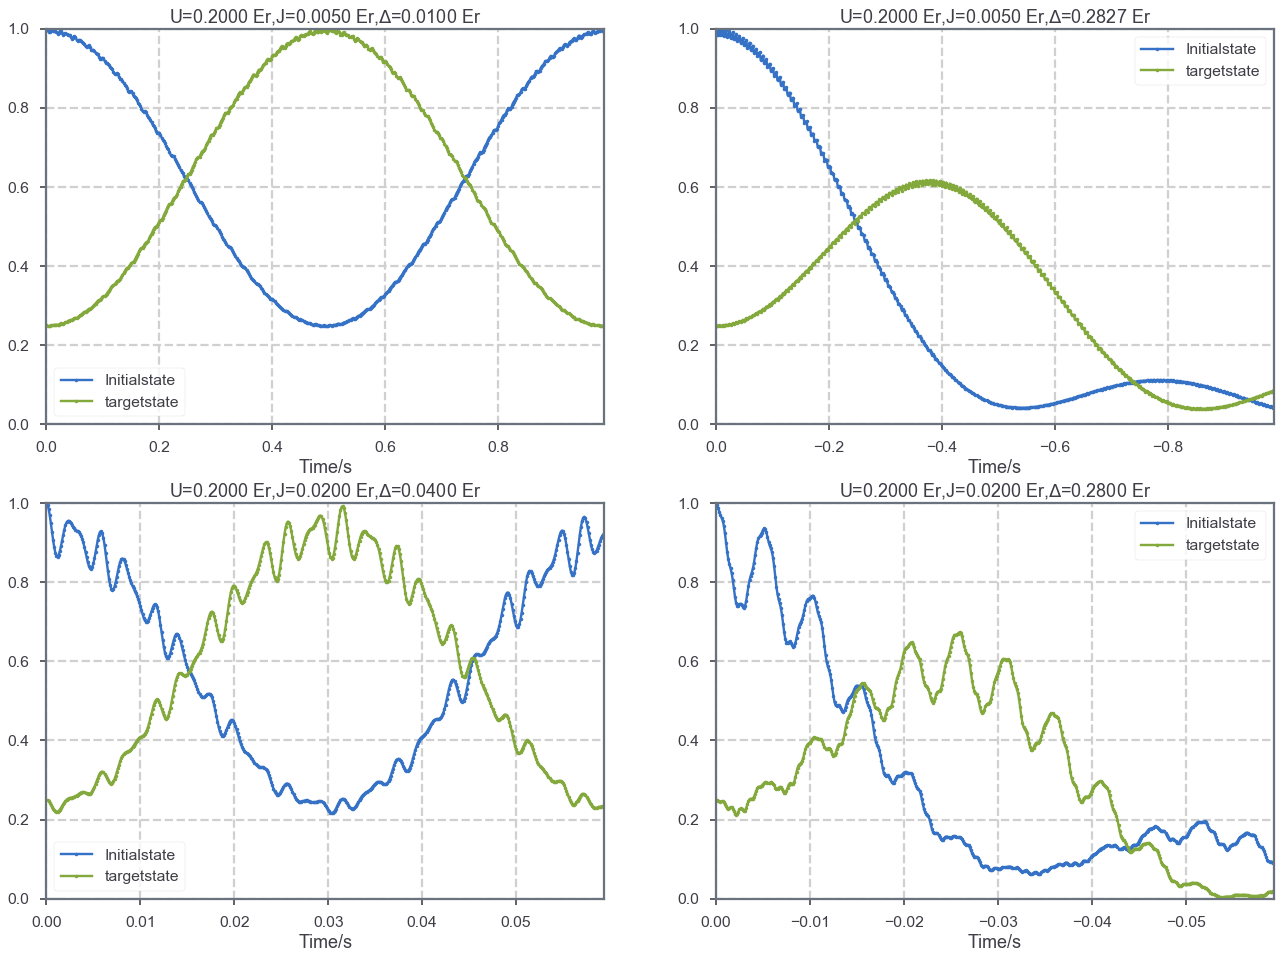

In [48]:
%%time

initialstate2=0.5*(1*qutip.basis(10,6)+1*qutip.basis(10,7)+1*qutip.basis(10,1)+1*qutip.basis(10,4))
initialstate2=initialstate2.unit()
targetstate=0.5*(1*qutip.basis(10,6)+1*qutip.basis(10,7)+1*qutip.basis(10,1)-1*qutip.basis(10,4))
#targetstate=(1*qutip.basis(10,8)+1*qutip.basis(10,9)).unit()

#np.linspace(0,20,6)

fig,axt=plt.subplots(2,2,figsize=(22,16))
ax=axt[0][0]

J=0.005*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.01*2*np.pi*2020

twopdy(U,J,td,ax,method='expm')

ax=axt[0][1]
ax.set_ylim((0,1))

# J=0.01*2*np.pi*2020
# U=0.2*2*np.pi*2020
# td=0.02*2*np.pi*2020
twopdy(U,J,np.sqrt(2*U**2-td**2),ax,method='expm') 
#twopdy(U,J,td,ax,method='expm')

ax=axt[1][0]
ax.set_ylim((0,1))

J=0.02*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.04*2*np.pi*2020

twopdy(U,J,td,ax,method='expm')
 

ax=axt[1][1]
ax.set_ylim((0,1))
# J=0.03*2*np.pi*2020
# U=0.2*2*np.pi*2020
# td=0.09*2*np.pi*2020
twopdy(U,J,np.sqrt(2*U**2-td**2),ax,method='expm') 
# for j in range(4):
#     ax[j//2][j%2].set_title(statelist[6+j]+',$\Delta=0$')
# for axis in ax:
#     axis.legend(loc='best')
# for axis in ax[1]:
#     axis.legend(loc='best')
# plt.figure(figsize=(15,9))
# plt.scatter(a,[freq[i][0] for i in a])

CPU times: user 4.3 s, sys: 72.7 ms, total: 4.37 s
Wall time: 4.83 s


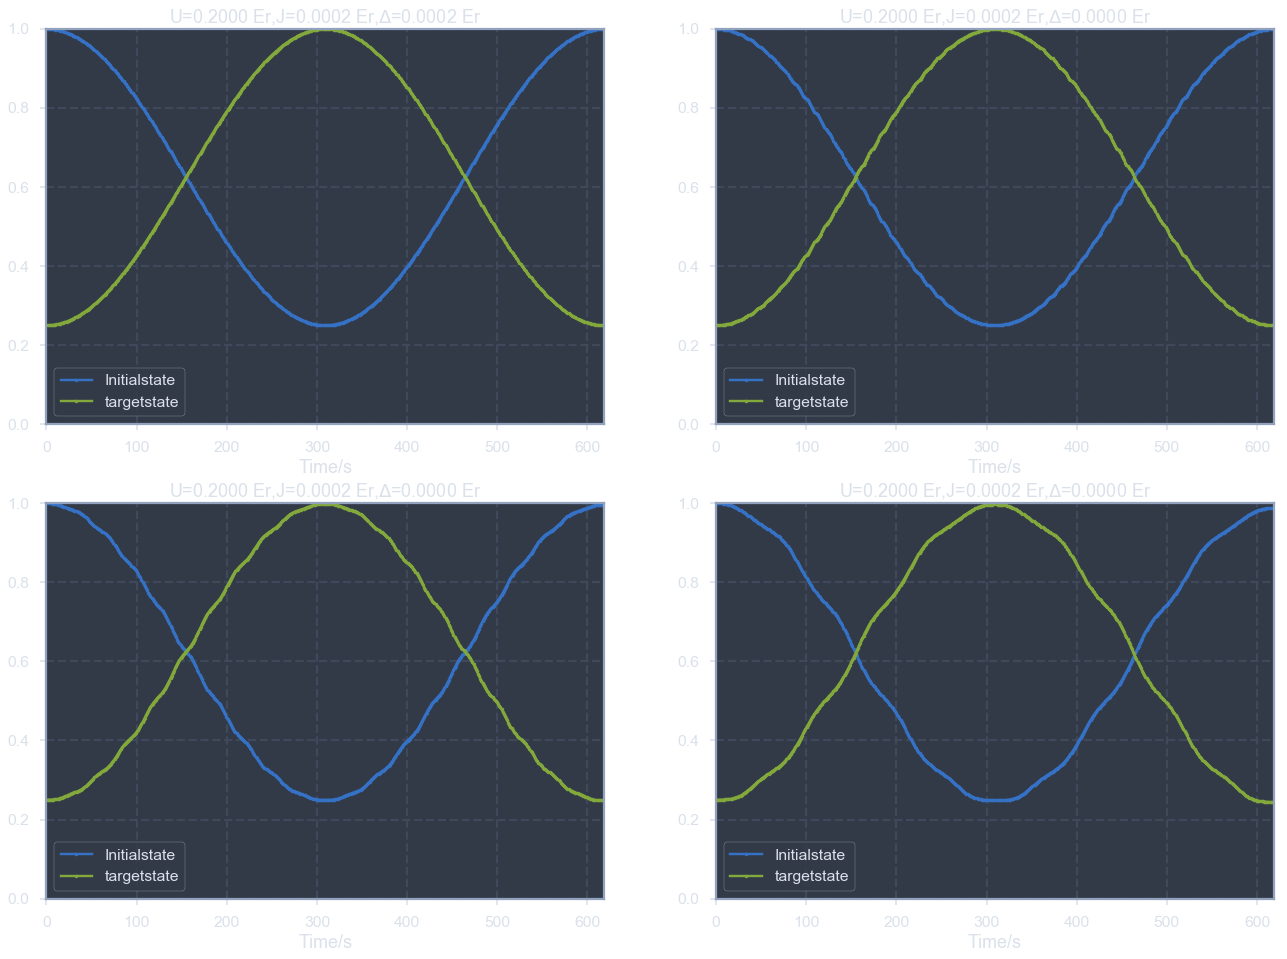

In [418]:
%%time

initialstate2=0.5*(1*qutip.basis(10,6)+1*qutip.basis(10,7)+1*qutip.basis(10,1)+1*qutip.basis(10,4))
initialstate2=initialstate2.unit()
targetstate=0.5*(1*qutip.basis(10,6)+1*qutip.basis(10,7)+1*qutip.basis(10,1)-1*qutip.basis(10,4))
#targetstate=(1*qutip.basis(10,8)+1*qutip.basis(10,9)).unit()

#np.linspace(0,20,6)

fig,axt=plt.subplots(2,2,figsize=(22,16))
ax=axt[0][0]

J=0.0002*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.0002*2*np.pi*2020

twopdy(U,J,td,ax,method='expm')

ax=axt[0][1]
ax.set_ylim((0,1))

J=0.0002*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.00002*2*np.pi*2020

twopdy(U,J,td,ax,method='expm')

ax=axt[1][0]
ax.set_ylim((0,1))

J=0.0002*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.000008*2*np.pi*2020

twopdy(U,J,td,ax,method='expm')
 

ax=axt[1][1]
ax.set_ylim((0,1))
J=0.0002*2*np.pi*2020
U=0.2*2*np.pi*2020
td=0.000004*2*np.pi*2020
twopdy(U,J,td,ax,method='expm') 
# for j in range(4):
#     ax[j//2][j%2].set_title(statelist[6+j]+',$\Delta=0$')
# for axis in ax:
#     axis.legend(loc='best')
# for axis in ax[1]:
#     axis.legend(loc='best')
# plt.figure(figsize=(15,9))
# plt.scatter(a,[freq[i][0] for i in a])

## Four atom spin chain, initial state is antiferramagnetic state.

In [161]:
def returnlist(m,n):
    comlist=[]
    if n==1:
        comlist.append([m])
        #print(comlist)
        return comlist
    else:        
        for i in range(m+1):
            for coml in returnlist(m-i,n-1):
                comlist.append([i]+coml)
                #print(comlist)
        return comlist

basestate=returnlist(2,4)
state42=[list(zip(a,b)) for a in basestate for b in basestate]
state42

In [162]:
checklist=[[1,-1,0,0],[0,1,-1,0],[0,0,1,-1]]

couple={}
for i in range(len(basestate)):
    state=basestate[i]
    couple[i]=[]
    for s0 in basestate:
        tmp=[state[k]-s0[k] for k in range(len(s0))]#np.array(state)-np.array(s0)
        if (tmp in checklist) or ([-a for a in tmp] in checklist):
            couple[i].append(s0)

print(couple) 

{0: [[0, 0, 1, 1]], 1: [[0, 0, 0, 2], [0, 0, 2, 0], [0, 1, 0, 1]], 2: [[0, 0, 1, 1], [0, 1, 1, 0]], 3: [[0, 0, 1, 1], [0, 1, 1, 0], [1, 0, 0, 1]], 4: [[0, 0, 2, 0], [0, 1, 0, 1], [0, 2, 0, 0], [1, 0, 1, 0]], 5: [[0, 1, 1, 0], [1, 1, 0, 0]], 6: [[0, 1, 0, 1], [1, 0, 1, 0]], 7: [[0, 1, 1, 0], [1, 0, 0, 1], [1, 1, 0, 0]], 8: [[0, 2, 0, 0], [1, 0, 1, 0], [2, 0, 0, 0]], 9: [[1, 1, 0, 0]]}


In [477]:
hamilo=np.zeros((len(state42),len(state42)))
J=0.02*2*np.pi*2020
U=20*J
for i in range(len(state42)):
    a,b=zip(*state42[i])
    #print(a)
    ha=basestate.index(list(a))
    hb=basestate.index(list(b))
    for s1 in couple[ha]:
        couplestate=list(zip(s1,b))
        #print(couplestate)
        index=state42.index(couplestate)
        #print(s1)
        if (2 in s1) or (2 in a): 
            hamilo[i,index]=2**0.5*J
        else:
            hamilo[i,index]=J
    for s1 in couple[hb]:
        couplestate=list(zip(a,s1))
        #print(couplestate)
        index=state42.index(couplestate)
        #print(s1)
        if (2 in s1) or (2 in b): 
            hamilo[i,index]=2**0.5*J
        else:
            hamilo[i,index]=J
    inter=0
    for ele in state42[i]:
        atomnum=sum(ele)
        inter+=atomnum*(atomnum-1)/2*U
    hamilo[i,i]=inter
        

hamilom=hamilo
hamilo=qutip.Qobj(hamilo)
hamilo

Quantum object: dims = [[100], [100]], shape = (100, 100), type = oper, isherm = True
Qobj data =
[[30460.88236921   358.9849414      0.         ...     0.
      0.             0.        ]
 [  358.9849414  15230.4411846    358.9849414  ...     0.
      0.             0.        ]
 [    0.           358.9849414  10153.6274564  ...     0.
      0.             0.        ]
 ...
 [    0.             0.             0.         ... 15230.4411846
    253.84068641     0.        ]
 [    0.             0.             0.         ...   253.84068641
  15230.4411846    358.9849414 ]
 [    0.             0.             0.         ...     0.
    358.9849414  30460.88236921]]

73
49.50495049504949
CPU times: user 30.1 s, sys: 503 ms, total: 30.6 s
Wall time: 31.9 s


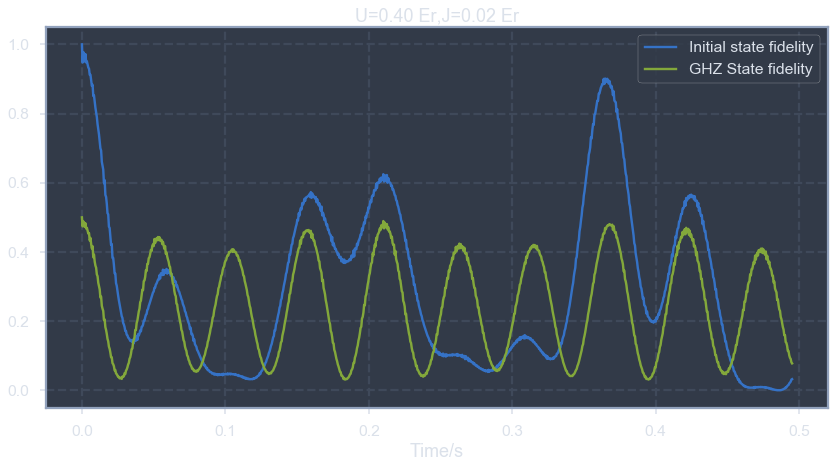

In [487]:
%%time
ini=list(zip([1,0,1,0],[0,1,0,1]))
iniindex=state42.index(ini)
ini1=list(zip([1,0,1,0],[0,1,0,1]))
iniindex1=state42.index(ini1)
ini2=list(zip([0,1,0,1],[1,0,1,0]))
iniindex2=state42.index(ini2)
print(iniindex)
initialstate4=qutip.basis(100,iniindex)
initialstate4=initialstate4.unit()
GHZstate=qutip.basis(100,iniindex1)+qutip.basis(100,iniindex2)
GHZstate=GHZstate.unit()

print(U**3*2*np.pi/(J**4)/4)
times4=np.linspace(0,U*2*np.pi/(J**2),1000)
#print(times4)
result4=qutip.essolve(hamilo,initialstate4,times4,[],[qutip.ket2dm(initialstate4),qutip.ket2dm(GHZstate)])#,options=qutip.Options(nsteps=50000))
#result5=qutip.mesolve(hamilo,result4.states[-1],times4,[],[qutip.ket2dm(qutip.basis(100,iniindex)),qutip.ket2dm((qutip.basis(100,iniindex)+qutip.basis(100,iniindex2)).unit())])

#print(result4.expect[1])
plt.figure(figsize=(14,7))
plt.title('U=%0.2f Er,J=%0.2f Er'%(U/(2*np.pi*2020),J/(2*np.pi*2020)))
plt.xlabel('Time/s')
plt.plot(times4,result4.expect[0],'-',ms=5.5,label='Initial state fidelity')
plt.plot(times4,result4.expect[1],'-',ms=5.5,label='GHZ State fidelity')
# # plt.plot(times4,result5.expect[0],'-',ms=5.5,label='initial state fidelity')
# # plt.plot(times4,result5.expect[1],'-',ms=5.5,label='GHZ State fidelity')
plt.legend(loc='best')

# #qutip.qsave(result,'evolutionresult')

In [488]:
#qutip.qsave(result,'evolutionresult')

twoatomloss=[]
for state in state42:
    sumstate=[sum(a) for a in state]
    if 2 in sumstate and 1 in sumstate:
        twoatomloss.append(state42.index(state))

print(twoatomloss)

[4, 7, 8, 13, 14, 15, 16, 17, 19, 23, 26, 28, 31, 32, 34, 36, 38, 39, 40, 41, 43, 47, 48, 49, 51, 56, 57, 61, 62, 63, 65, 67, 68, 70, 71, 74, 75, 76, 78, 80, 82, 83, 84, 86, 87, 91, 93, 94]


CPU times: user 1min 17s, sys: 2.86 s, total: 1min 20s
Wall time: 41.2 s


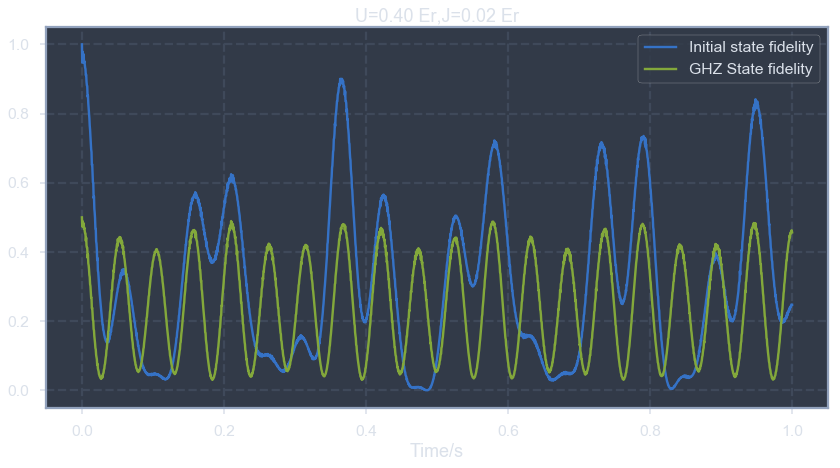

In [517]:
%%time
statearray=initialstate4.full()
ghzsta=GHZstate.full()
evostates=[]
fidelityini=[]
fidelityghz=[]
timesnew=np.linspace(0,2*U*2*np.pi/(J**2),2000)
for t in timesnew:
    state=np.dot(expm(-1j*hamilom*t),statearray)
    evostates.append(state)
    fidelityini.append((np.abs(np.dot(state.T,statearray))**2)[0][0])
    fidelityghz.append((np.abs(np.dot(state.T,ghzsta))**2)[0][0])
plt.figure(figsize=(14,7))
plt.title('U=%0.2f Er,J=%0.2f Er'%(U/(2*np.pi*2020),J/(2*np.pi*2020)))
plt.xlabel('Time/s')
plt.plot(timesnew,fidelityini,'-',ms=5.5,label='Initial state fidelity')
plt.plot(timesnew,fidelityghz,'-',ms=5.5,label='GHZ State fidelity')
# # plt.plot(times4,result5.expect[0],'-',ms=5.5,label='initial state fidelity')
# # plt.plot(times4,result5.expect[1],'-',ms=5.5,label='GHZ State fidelity')
plt.legend(loc='best')

-59.683103659460755
-238.73241463784302


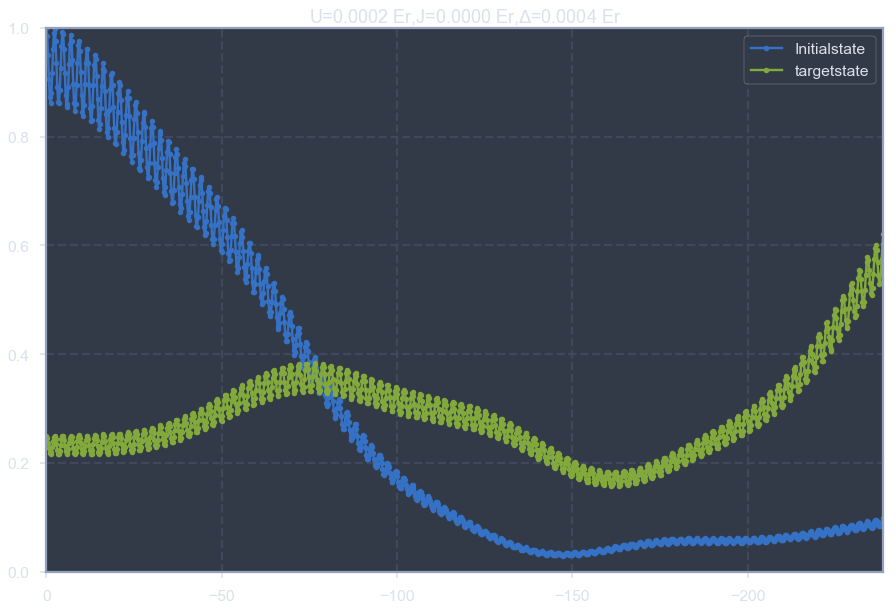

In [170]:
fig,ax=plt.subplots(1,1,figsize=((15,10)))

ax.set_ylim((0,1))

J=0.02*2*np.pi*2
U=10*J
td=20*J

period=(J**2/(U-td)+J**2/(U+td))**(-1)
print(period)
times=np.linspace(0,4*period,1000)
ax.set_title('U=%0.4f Er,J=%0.4f Er,$\Delta$=%0.4f Er'%(U/(2*np.pi*2020),J/(2*np.pi*2020),td/(2*np.pi*2020)))
ax.set_xlim((0,times[-1]))
ham2=hami(J,U,td)
result2=qutip.essolve(ham2,initialstate2,times,[],[qutip.ket2dm(initialstate2),qutip.ket2dm(targetstate)])
#     fittedresult=curve_fit(func,times,result2.expect[0])#,bounds=(0, 20), method='trf')
#     freqtmp=fittedresult[0][1]
#     lowertmp=1-fittedresult[0][0]
#     freq[i]=[freqtmp,lowertmp]
#     print(fittedresult[0])
    #ax[0][0].plot(times,func(times,fittedresult[0][0],fittedresult[0][1]))
print(times[-1])
ax.plot(times,result2.expect[0],'o-',ms=5.5,label='Initialstate')
ax.plot(times,result2.expect[1],'o-',ms=5.5,label='targetstate')
ax.legend(loc='best')

[46 64 81 18 37 73] [0.45037344 0.45037344 0.55407414 0.64738533 0.89868277 0.99289724]
[(0, 1), (1, 0), (1, 0), (0, 1)]
[(1, 0), (0, 1), (0, 1), (1, 0)]
[(1, 0), (1, 0), (0, 1), (0, 1)]
[(0, 1), (0, 1), (1, 0), (1, 0)]
[(0, 1), (1, 0), (0, 1), (1, 0)]
[(1, 0), (0, 1), (1, 0), (0, 1)]


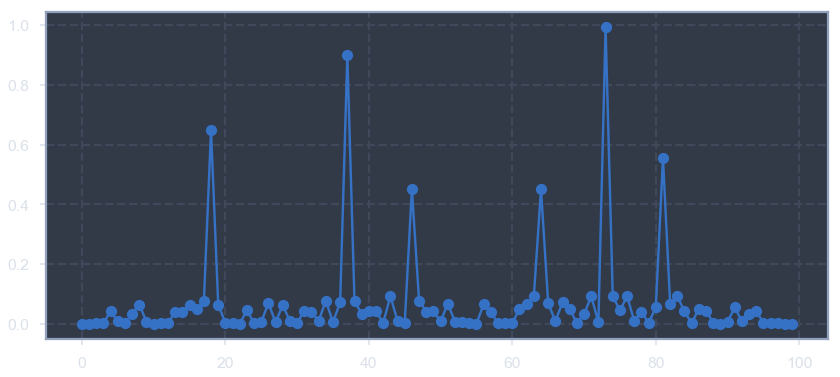

In [518]:
statesew=np.array(evostates)
tmp1=np.max(np.abs(statesew),axis=0)-np.min(np.abs(statesew),axis=0)
tmp1=tmp1.reshape(100,)
plt.figure(figsize=(14,6))
plt.plot(tmp1,'o-')
ui=tmp1.argsort()[-6:]
print(ui,tmp1[ui])
for i in ui:
    print(state42[i])
#statesew[100,99,0]
# for i in range(100):
#     print(np.abs(np.max(statesew[:,i]))-np.abs(np.min(statesew[:,i])))

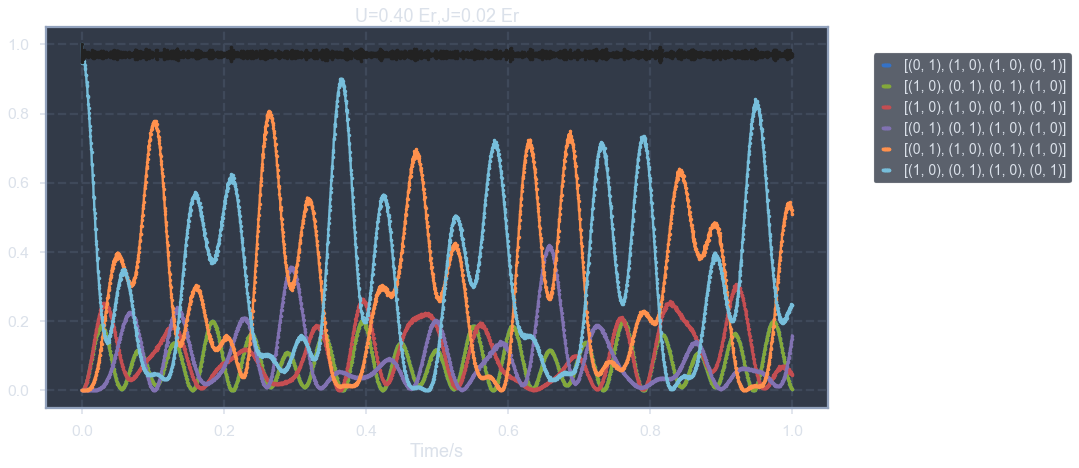

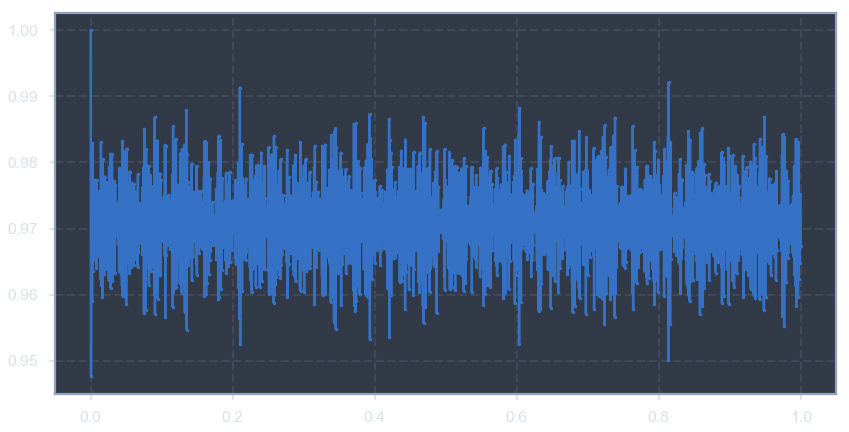

In [519]:
plt.figure(figsize=(14,7))
plt.title('U=%0.2f Er,J=%0.2f Er'%(U/(2*np.pi*2020),J/(2*np.pi*2020)))
plt.xlabel('Time/s')
for i in ui:
    plt.plot(timesnew,np.abs(statesew[:,i])**2,'o-',ms=3.5,label=str(state42[i]))
plt.plot(timesnew,np.sum(np.abs(statesew[:,ui])**2,axis=1),'o-',ms=3.5)
#plt.plot(timesnew[:50],(np.abs(statesew[:,:]))**2,'o-',ms=5.5,label=str(state42[i]))
#plt.plot(timesnew,fidelityghz,'-',ms=5.5,label='GHZ State fidelity')
# # plt.plot(times4,result5.expect[0],'-',ms=5.5,label='initial state fidelity')
# # plt.plot(times4,result5.expect[1],'-',ms=5.5,label='GHZ State fidelity')
plt.legend(loc='best',
           fontsize='17',bbox_to_anchor=(1.05,0.95), numpoints=15,prop={'size':14}, handlelength=1.0, handletextpad=0.8)

plt.figure(figsize=(14,7))
plt.plot(timesnew,np.sum(np.abs(statesew[:,ui])**2,axis=1),'o-',ms=3.5)

In [341]:
atat=[]
for a in x:
    for b in y:
        t=[a,b,10]
        atat.append(t)
print(atat)
        

[[0.0, 0.0, 10], [0.0, 2.0, 10], [0.0, 4.0, 10], [5.0, 0.0, 10], [5.0, 2.0, 10], [5.0, 4.0, 10], [10.0, 0.0, 10], [10.0, 2.0, 10], [10.0, 4.0, 10]]


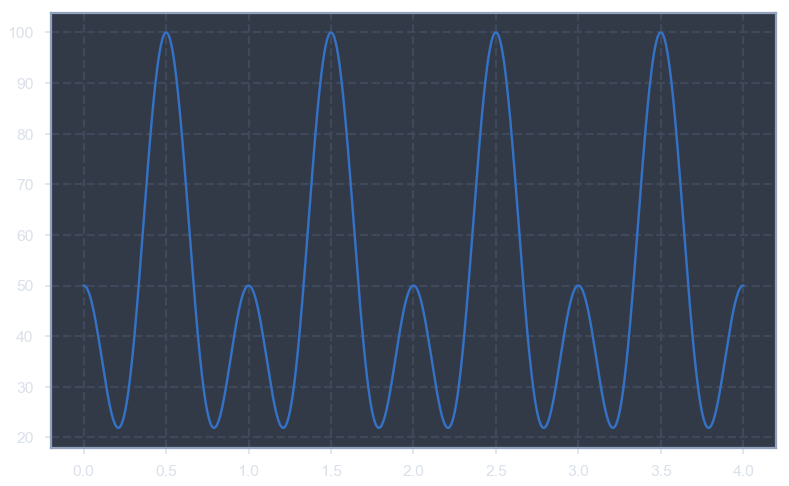

In [838]:
V1=50
V2=50
fi=0*np.pi
xi=np.linspace(0,4,1000)
sl=V1*np.cos(2*np.pi*xi)**2
ll=V2*np.sin(np.pi*xi+fi)**2
plt.figure(figsize=(13,8))
plt.plot(xi,sl+ll)
plt.figure(figsize=(13,8))
#plt.plot(xi,V1*2*np.pi*np.sin(2*np.pi*xi)*np.cos(2*np.pi*xi)+V2*np.pi*np.sin(np.pi*xi+fi)*np.cos(np.pi*xi+fi))

In [724]:
list(range(6,9))

In [760]:
t=np.array([1,2,3])

In [766]:
t[-1::-1]

array([3, 2, 1])